In [1]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the CICIDS2017 dataset. 
# implemented Weighted Stacking Ensemble technique to improve the performance of the model. 

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/Intrusion_Detection_System_IDS/Advanced_Ensemble_techniques/Stacking/CICIDS2017_combined_dataset.csv')

# Drop duplicates: same observation but multiple occurences
main_df_1 = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value, the model wont learn form columns like this.
one_value = main_df_1.columns[main_df_1.nunique() == 1]
main_df_2 = main_df_1.drop(columns = one_value, axis=1)

# Fill nan values
main_df_2['Flow Bytes/s'] = main_df_2['Flow Bytes/s'].fillna(main_df_2['Flow Bytes/s'].mean())

# Remove leading space character in all feature names
main_df_2.rename(columns=lambda x: x.lstrip(), inplace=True)

sample_df_1 = main_df_2.copy()
# Extract subsample of data
print (" Extract subsample of data: ")
print (sample_df_1['Label'].value_counts())


/tmp/ipykernel_212093/2742706865.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


 Extract subsample of data: 
Label
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [2]:
# Label encoding to convert categorical data to numerical data
le = LabelEncoder()
sample_df_1['Label'] = le.fit_transform(sample_df_1['Label'])

# Extract subsample of data
print (" Extract subsample of data: ")
print (sample_df_1['Label'].value_counts())

 Extract subsample of data: 
Label
0     2096484
4      172849
2      128016
10      90819
3       10286
7        5933
6        5385
5        5228
11       3219
1        1953
12       1470
14        652
9          36
13         21
8          11
Name: count, dtype: int64


In [3]:
# Take a random sample of the dataset
# sample_df_1 = sample_df_1.sample(frac= 0.05, random_state=42)

print("Sampled Dataset Overview:")

# feature_names = list(sample_df_1.columns[:-2]) 
# target_names = ['Benign', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttp', 'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack - Brute Force', 'Web Attack - Sql Injection', 'Web Attack - XSS']

dropped_df = ['Label', 'Flow Packets/s', 'Flow Bytes/s']
X = sample_df_1.drop( dropped_df, axis=1) 
y = sample_df_1['Label']  


Sampled Dataset Overview:


In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# initialize the models
model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3= RandomForestClassifier()


In [6]:
# Train the models
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)


RandomForestClassifier()

In [7]:
# Predictions 
# We use the predict_proba method to get the probabilities of each class
pred1=model1.predict_proba(X_test)
pred2=model2.predict_proba(X_test)
pred3=model3.predict_proba(X_test)


In [8]:
# Final prediction and 0.4 0.3 0.3 weights are used
# and 0.4 0.3 0.3 weights mean that 40% of the weight is given to the first model, 30% to the second model, and 30% to the third model.
finalpred=((pred1 * 0.4 ) +(pred2*0.3)+(pred3*0.3))

In [9]:
# Convert probabilities to class predictions
# argmax returns the index of the maximum value in a row
final_class_pred_enc = np.argmax(finalpred, axis=1)


In [10]:
# Use inverse_transform to get original labels
y_pred = le.inverse_transform(final_class_pred_enc)
y_test_labels = le.inverse_transform(y_test)

# # Create a mapping between numerical labels and their corresponding real labels
# label_mapping = {label: le.inverse_transform([label])[0] for label in set(y_test)}
# print (label_mapping)


In [11]:
# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9983956844705164


In [12]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    628642
                       Bot       0.85      0.83      0.84       575
                      DDoS       1.00      1.00      1.00     38338
             DoS GoldenEye       1.00      1.00      1.00      3122
                  DoS Hulk       1.00      1.00      1.00     52061
          DoS Slowhttptest       0.99      0.99      0.99      1576
             DoS slowloris       0.99      0.99      0.99      1636
               FTP-Patator       1.00      1.00      1.00      1758
                Heartbleed       1.00      0.80      0.89         5
              Infiltration       0.83      0.62      0.71         8
                  PortScan       0.99      0.99      0.99     27368
               SSH-Patator       1.00      1.00      1.00       966
  Web Attack � Brute Force       0.72      0.79      0.76       448
Web Attack � Sql Inject

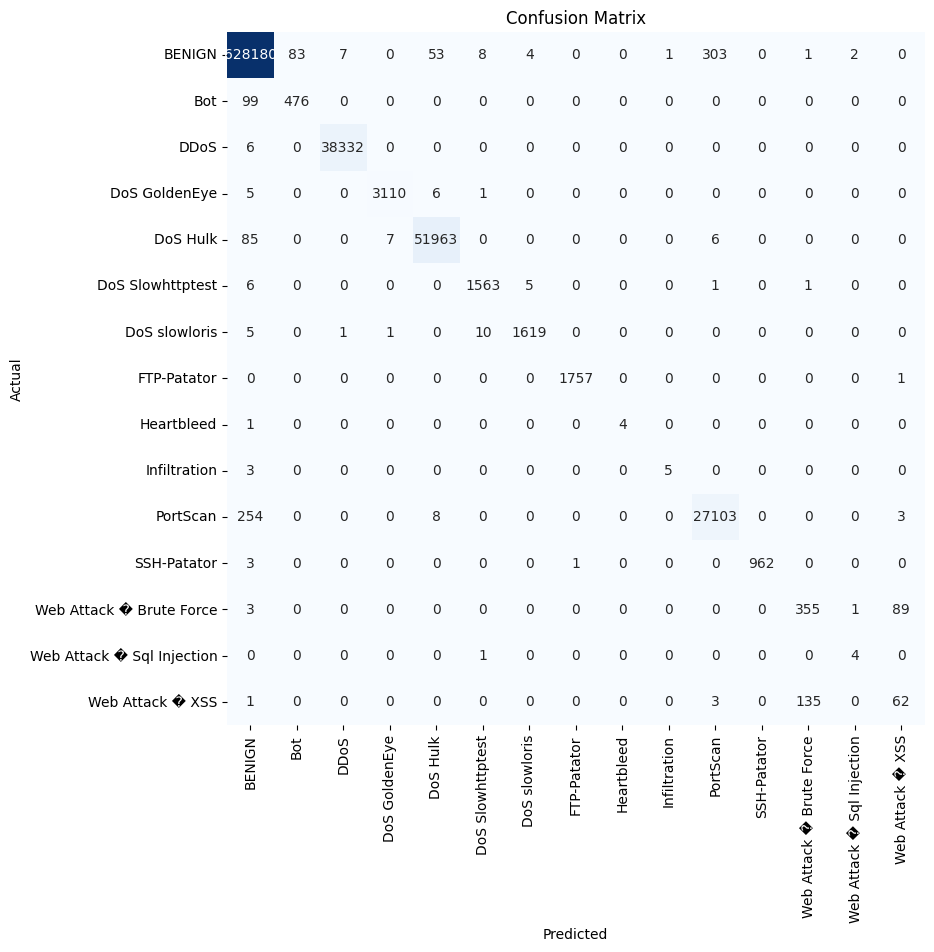

In [13]:
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred, labels=le.classes_)

# Plotting the Confusion Matrix
plt.figure(figsize=(9, 9))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=le.classes_.tolist(), yticklabels=le.classes_.tolist())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

